# A moving ball - A Multimesh Motivation


This notebook contains an comparasion of a single-mesh and multimesh approach for a ball moving with a constant speed in a channel.
We start by importing the packages needed.

In [1]:
from dolfin import *
import matplotlib.pyplot as plt

We then create a single mesh, describing an obstacle in a channel, with *pygmsh* and *gmsh*, and convert it to a dolfin readable format using *meshio*. We use the functions located in **motivation_meshes.py
** to create the meshes.

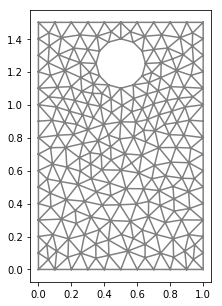

In [2]:
%load_ext autoreload
from motivation_meshes import single_mesh, background_mesh, front_mesh, outer_marker, inner_marker
single_mesh(0.1)
mesh = Mesh()
with XDMFFile("singlemesh.xdmf") as infile:
    infile.read(mesh)
mvc = MeshValueCollection("size_t", mesh, 1)
with XDMFFile("mf_singlemesh.xdmf") as infile:
    infile.read(mvc, "name_to_read")
mf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

%matplotlib inline
plt.figure(figsize=(5,5))
plot(mesh)
plt.show()

Thereafter, we create a function describing the velocity field of the ball. To only create a vector field that
is non-zero on the ball, we use a *DirichletBc*.

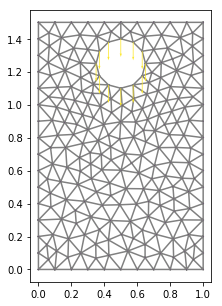

(0.6984894479044751, 0.9997674962782043)


In [3]:
V = VectorFunctionSpace(mesh, "CG", 1)
velocity = Function(V)
bc_v = DirichletBC(V, Constant((0,-0.1)), mf, inner_marker)
bc_v.apply(velocity.vector())
plt.figure(figsize=(5,5))
plot(mesh, zorder=0)
plot(velocity,zorder=1, color="b",scale=1)
plt.show()
print(MeshQuality.radius_ratio_min_max(mesh))

When the ball starts falling, we need to update the mesh. We use a smoothed $H^1(\Omega)$-representation of the function that is $(0,-0.02)$ on the ball and $(0,0)$ on the outer boundaries.

In [4]:
# Chooste timestep used in deformation
dt = 0.1
# Set boundary conditions for velocity field
b_outer = DirichletBC(V, Constant((0,0)), mf, outer_marker)
bc_displacement = DirichletBC(V, dt*velocity, mf, inner_marker)
bcs = [b_outer, bc_displacement]
u, v = TrialFunction(V), TestFunction(V)
# Smoothed H1 representation as variational form
a = 0.1*inner(grad(u), grad(v))*dx + inner(u,v)*dx
l = inner(Constant((0,0)),v)*dx
displacement = Function(V)

We define a function for the falling ball until time `t=T_end` as

In [5]:
%matplotlib inline
import time

def falling_ball(T_end):
    fig = plt.figure(figsize=(10,10))
    org_position=mesh.coordinates().copy()
    # Compute displacement field at time T_end
    t_0 = 0
    start = time.time()
    while t_0<=T_end:
        A, L = assemble(a), assemble(l)
        [bc.apply(A, L) for bc in bcs]
        solve(A, displacement.vector(), L)
        # Move mesh
        ALE.move(mesh, displacement)
        t_0+=dt
        end = time.time()
    plot(mesh, color="r")
    plt.title("Runtime from t=0 to t={0:.1f}: {1:.2e} seconds".format(T_end, end-start))
    plt.show()
    mesh.coordinates()[:]=org_position


With the slider below, one can explore how the mesh changes as the ball moves. As you note, computing the mesh movement of the ball is time consuming, and the visualization lags behind the movement of the slider

In [6]:
from ipywidgets import interact
import ipywidgets as widgets
interact(falling_ball, T_end=(0,10,0.5))

interactive(children=(FloatSlider(value=5.0, description='T_end', max=10.0, step=0.5), Output()), _dom_classes…

<function __main__.falling_ball(T_end)>

As we can observe from the images above, the mesh degenerates with large movements, and the mesh-deformation is time-consuming.
We therefore introduce another way of representing the ball, namely with **Multiple meshes**.
We import two different meshes from *motivation_meshes.py*


In [7]:
%matplotlib notebook
front_mesh(0.1)
background_mesh(0.1)
mesh_files = ["background_mesh.xdmf", "front_mesh.xdmf"]
mf_files = ["mf_background.xdmf", "mf_front.xdmf"]
# We create the MultiMesh object containing both meshes
multimesh = MultiMesh()
mfs = []
for i in range(2):
    mesh_i = Mesh()
    with XDMFFile(mesh_files[i]) as infile:
        infile.read(mesh_i)
        multimesh.add(mesh_i)
    mvc = MeshValueCollection("size_t", mesh_i, 1)
    with XDMFFile(mf_files[i]) as infile:
        infile.read(mvc, "name_to_read")
    mfs.append(cpp.mesh.MeshFunctionSizet(mesh_i, mvc))

We now visualize the meshes in the `MultiMesh`-object

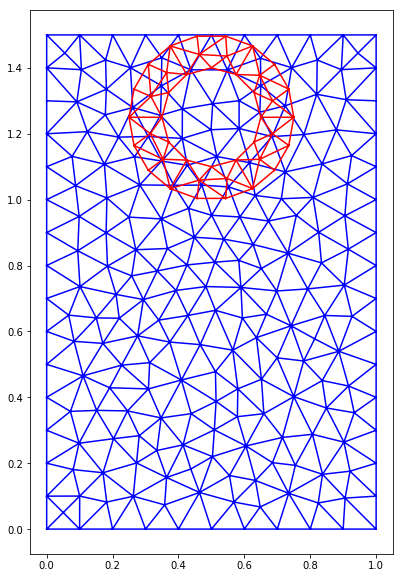

In [8]:
%matplotlib inline
colors = ["b", "r"]
fig = plt.figure(figsize=(10,10))
for i in range(multimesh.num_parts()):
    plot(multimesh.part(i), zorder=i, color=colors[i])
plt.show()

We compute the intersections between the meshes, mark the cells inside the object and deactivate them with the following commands

In [9]:
multimesh.build()
center_of_ball = Point(0.5,1.2)
multimesh.auto_cover(0, center_of_ball)

We create a function that moves the upper mesh. Here no mesh deformation is needed, and translating the cells are faster
and more robust than deforming them

This method is both faster and more stable than the single-mesh deformation approach. Finally, we save the final multimesh as an svg-file.

In [10]:
def falling_ball_multimesh(T_end):
    start = time.time()
    org_position=multimesh.part(1).coordinates().copy()
    # Compute displacement field at time T_end
    displacement = Point(0, -0.1*T_end)
    multimesh.part(1).translate(displacement)
    end = time.time()
    fig = plt.figure(figsize=(10,10))
    plot(multimesh.part(0), zorder=0)
    plot(multimesh.part(1), color="r")
    plt.title("Runtime from t=0 to t={0:.1f}: {1:.2e} seconds".format(T_end, end-start))
    plt.show()
    multimesh.part(1).coordinates()[:]=org_position
interact(falling_ball_multimesh, T_end=(0,10,0.5))

interactive(children=(FloatSlider(value=5.0, description='T_end', max=10.0, step=0.5), Output()), _dom_classes…

<function __main__.falling_ball_multimesh(T_end)>

One observes that the mesh quality is constant and that the runtime is from 2 to 4 orders of magnitude faster than the traditional FEM.